This is the second home analysis.

Similiar NerdWallet Research
- Best places for minority owned business - https://www.nerdwallet.com/blog/small-business/best-places-for-minority-owned-businesses/
- Women entrepreneurs - https://www.nerdwallet.com/blog/small-business/women-entrepreneurs-small-business-loans/
- Best small cities - (https://www.nerdwallet.com/blog/cities/best-small-cities-america-2015/)
- Small cities to start business (https://www.nerdwallet.com/blog/small-business/top-small-cities-start-business-2015/)
- southern metro areas - https://www.nerdwallet.com/blog/mortgages/southern-metro-areas-housing-homeownership-2015/
- start a restaurant - https://www.nerdwallet.com/blog/small-business/start-restaurant/




## Base Criteria
When looking for a home I want something that is going up in value, makes money renting, cheap to invest in a home, and in a region that has seasonal occupants


In [63]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import statsmodels.api as sm  

from matplotlib.patches import Circle, Rectangle, Arc
from geopy.geocoders import Nominatim
from descartes import PolygonPatch
from pyproj import Proj, transform
import json
from shapely.geometry import mapping, shape, LineString, Point


import seaborn as sb  
sb.set_style('darkgrid')



In [64]:

def plot_polygon(ax, coordlist, edgecolor, color='white', alpha=0.5):    
    poly = {"type": "Polygon", "coordinates": coordlist}
    ax.add_patch(PolygonPatch(poly, facecolor='white', edgecolor='black', linewidth=1.0, alpha=alpha))
    ax.plot(coordlist[:, 0],coordlist[:, 1], color='w')


def plot_multipolygon(ax, geom, color='red'):
    """ Can safely call with either Polygon or Multipolygon geometry
    change from original
    """
    if geom['type'] == 'Polygon':
        a = np.asarray(geom['coordinates'])
        plot_polygon(ax, a, color)
    elif geom['type'] == 'MultiPolygon':
         for g in geom['coordinates']:
            a = np.asarray(g)
            plot_polygon(ax, a, color)
    




Zillow Price of home for all cities

In [65]:
df = pd.read_csv('data/City_Zhvi_AllHomes.csv')


Price to Rent Ratio for Zillow

In [66]:
df_price_2_rent = pd.read_csv('data/City_PriceToRentRatio_AllHomes.csv')



### Existing climate for vacation rentals:
Area with vacation rentals? Analyze only cities that are in a county where more than 20% of the households are for recreational use.

In [67]:
## Vacation or not occupied

df['CountyState'] = df['CountyName'] + " County, " + df['State']

df_price_2_rent['CityState'] = df_price_2_rent['RegionName'] + ', ' + df_price_2_rent['State']

df['CityState'] = df['RegionName'] + ', ' + df['State']
new_df = pd.merge(df, df_price_2_rent, on='CityState', how='inner')


## Add seasonal data

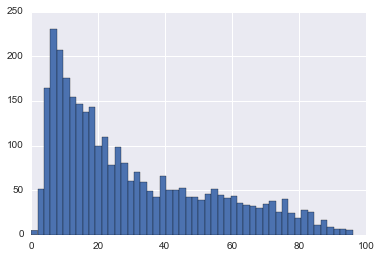

In [68]:
xl = pd.ExcelFile('data/seasonal_rates.csv')
df_seasonal = xl.parse('seasonal_rates.csv')
plt.hist(df_seasonal['seasonal use'], bins=50)


# df_seasonal = df_seasonal[df_seasonal['seasonal use'] > 20.0]

df_seasonal['CountyState'] = df_seasonal['Geographic area'] + ', ' + df_seasonal['State Abbr']
seasonal_df = pd.merge(new_df, df_seasonal, on='CountyState', how='inner')


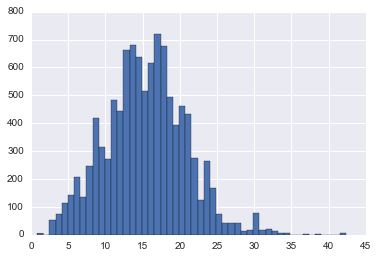

In [69]:
plt.hist(seasonal_df['For sale only'], bins=50);

## Basis for proximity
If you are buying a vacation home, proximity to attractions is important. I included a lat/long to check for reference.

Attached a latitude and longitude

In [70]:
# add geo location
df_geo = pd.read_csv('data/us_cities.csv')

# combine the city and state for merging
df_geo['CityState'] = df_geo['AccentCity'] + ', ' + df_geo['Region']
df_geo = pd.merge(seasonal_df, df_geo, on='CityState', how='inner')

#### Plot where the current locations are.

In [71]:
def add_us_outline(ax):
    with open('data/us_states.geojson') as data_file:    
        data = json.load(data_file)
        
    for feature in data['features']:
        plot_multipolygon(ax, feature['geometry'], color='black')
    
    #set the graph axes to the feature extents
    ax.set_xlim(-160.6708333, -65.9038889)
    ax.set_ylim(18.0638889, 50.0002778)
    

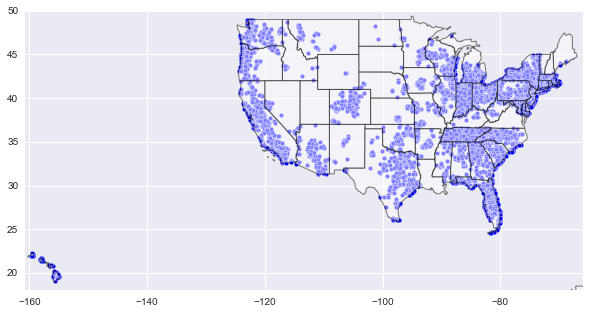

In [72]:
fig = plt.figure(figsize=(10,5))
ax = plt.gca()
add_us_outline(ax)
ax.scatter(df_geo['Longitude'], df_geo['Latitude'], marker='o', edgecolor='w');


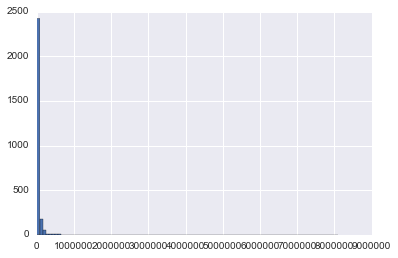

In [73]:
plt.hist(df_geo['Population'].dropna(), bins=100);

### Investment: 
looking for upward trending growth in the value of the homes

In [74]:
df_geo['growth'] = (df_geo['2016-03_x'] - df_geo['2011-03_x']) / df_geo['2011-03_x']

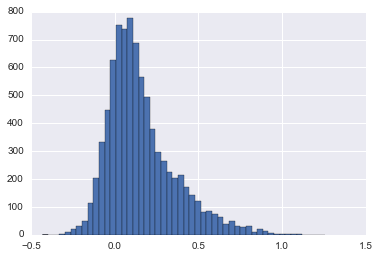

In [75]:
plt.hist(df_geo['growth'].dropna(), bins=50);


In [76]:
# calculate growth

max_growth, min_growth = max(df_geo['growth']), min(df_geo['growth'])
difference = max_growth - min_growth

df_geo['growth_index'] = 100*(df_geo['growth'] - min_growth) / difference


### Revenue (Price to Rent)
The Price to Rent Ratio is the median ratio between a home's value and annualized rent.

It would be great to have this for the annual rate for investment

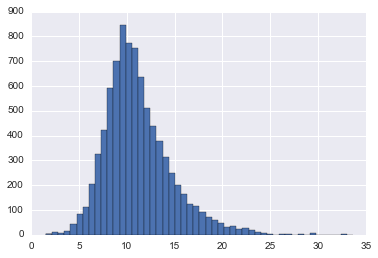

In [77]:
plt.hist(df_geo['2016-03_y'].dropna(), bins=50);

In [78]:
max_revenue, min_revenue = max(df_geo['2016-03_y']), min(df_geo['2016-03_y'])
difference = max_revenue - min_revenue

df_geo['revenue_index'] = 100*(max_revenue - df_geo['2016-03_y']) / difference

df_geo['old_revenue_index'] = 100*(df_geo['2016-03_y'] - min_revenue) / difference

# df_geo[['revenue_index', '2016-03_y']].sort('revenue_index', ascending=False)


### Home Price
The lower the price the higher the index.

The median home value is $169000.0


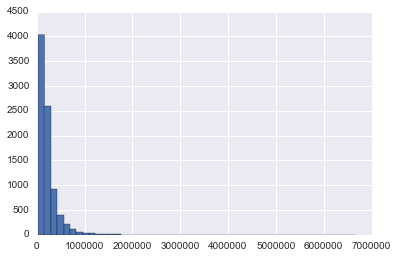

In [79]:
plt.hist(df_geo['2016-03_x'], bins=50);
print("The median home value is $" + str(df_geo['2016-03_x'].median()))

In [80]:
max_price, min_price = max(df_geo['2016-03_x']), min(df_geo['2016-03_x'])
difference = max_price - min_price
df_geo['price_index'] = 100*(max_price - df_geo['2016-03_x'] ) / difference


## Renters


the percentage of renters in the area.

In [81]:
min_seasonal, max_seasonal = min(df_geo['seasonal use']), max(df_geo['seasonal use'])
difference = max_seasonal - min_seasonal
df_geo['env_index'] = 100*(df_geo['seasonal use'] - min_seasonal) / difference


## Base Analysis
Subsequent analysis will use this the analysis as the basis and focus on regions

In [83]:
df_geo['index'] = (.30 * df_geo['growth_index']) + (.30 * df_geo['price_index']) + (.30 * df_geo['revenue_index']) + (.10 * df_geo['env_index'])


# sort descending from the highest index down and limit the top 10
df_out = df_geo.sort('index', ascending=False).head(10)
df_out['Home Value in USD'] = df_out['2016-03_x']
df_out['Price to Rent'] = df_out['2016-03_y']
df_out['growth rate'] = df_out['growth'].apply(lambda x: str("%.2f" % (x * 100)) + " %")
df_out['monthly rent'] = (df_out['2016-03_x'] / df_out['2016-03_y']).apply(lambda x: int(x / 12))

df_out[['RegionName_x', 'State_x', 'index', 'Home Value in USD', 'Price to Rent', 'growth rate', 'monthly rent','seasonal use']]


,RegionName_x,State_x,index,Home Value in USD,Price to Rent,growth rate,monthly rent,seasonal use
1437,Lehigh Acres,FL,86.148716,126900,9.26,114.72 %,1142,55.8
5571,Golden Gate,FL,85.933024,202600,8.40,102.80 %,2009,69.4
1525,Golden Lakes,FL,83.505419,70000,5.09,79.95 %,1146,50.0
1517,Palm Springs,FL,83.336956,124800,7.87,95.00 %,1321,50.0
4095,Kensington Park,FL,83.121668,158600,9.03,95.08 %,1463,59.5
658,Leisure City,FL,82.661397,136600,7.49,100.59 %,1519,31.4
4425,Yeehaw Junction,FL,81.276911,158500,10.45,93.29 %,1263,57.6
4426,Poinciana,FL,81.054447,132400,9.82,88.07 %,1123,57.6
1929,Broadview Park,FL,81.009600,158300,8.18,87.78 %,1612,44.3
1920,North Lauderdale,FL,80.975046,143200,7.90,85.73 %,1510,44.3


## Where are they located?


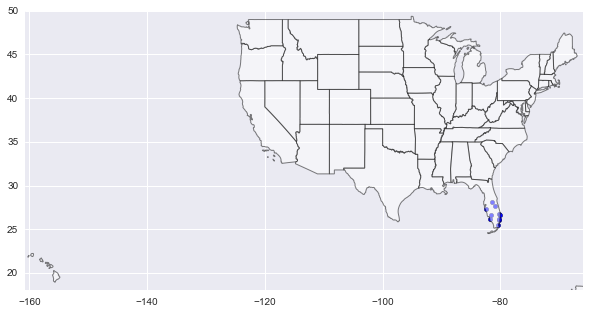

In [25]:
fig = plt.figure(figsize=(10,5))
ax = plt.gca()
add_us_outline(ax)
ax.scatter(df_out['Longitude'], df_out['Latitude'], marker='o');



## Key Takeaways
1. price to rent is not the best since these would most likely be short term rentals. I need a
2. everything is in South Florida.
3. A lot of small towns


In [26]:
df_geo['new index'] = (.45 * df_geo['growth_index']) + (.45 * df_geo['revenue_index']) + (.10 * df_geo['env_index'])


# sort descending from the highest index down and limit the top 10
df_out = df_geo.sort('index', ascending=False).head(10)
df_out['Home Value in USD'] = df_out['2016-03_x']
df_out['growth rate'] = df_out['growth'].apply(lambda x: str("%.2f" % (x * 100)) + " %")

df_out[['RegionName_x', 'State_x', 'index', 'Home Value in USD', 'growth rate','seasonal use']]

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,RegionName_x,State_x,index,Home Value in USD,growth rate,seasonal use
1437,Lehigh Acres,FL,86.148716,126900,114.72 %,55.8
5571,Golden Gate,FL,85.933024,202600,102.80 %,69.4
1525,Golden Lakes,FL,83.505419,70000,79.95 %,50.0
1517,Palm Springs,FL,83.336956,124800,95.00 %,50.0
4095,Kensington Park,FL,83.121668,158600,95.08 %,59.5
658,Leisure City,FL,82.661397,136600,100.59 %,31.4
4425,Yeehaw Junction,FL,81.276911,158500,93.29 %,57.6
4426,Poinciana,FL,81.054447,132400,88.07 %,57.6
1929,Broadview Park,FL,81.009600,158300,87.78 %,44.3
1920,North Lauderdale,FL,80.975046,143200,85.73 %,44.3


## Above a certain population
I have not heard of these cities. Find cities with populations above 100K

In [28]:
# sort descending from the highest index down and limit the top 10


df_out = df_geo[df_geo['Population'] > 100000].sort('index', ascending=False).head(10)

df_out[['RegionName_x', 'State_x', 'Population', 'index', '2016-03_x', '2016-03_y', 'growth', 'seasonal use']]

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,RegionName_x,State_x,Population,index,2016-03_x,2016-03_y,growth,seasonal use
1436,Cape Coral,FL,130807,77.971541,200200,11.03,0.798742,55.8
1371,San Bernardino,CA,202381,74.532503,223300,13.55,0.845455,38.7
1906,Hollywood,FL,144821,74.503549,220000,10.45,0.646707,44.3
2433,Richmond,CA,103041,74.081780,397400,15.02,1.114955,9.6
1312,Saint Petersburg,FL,246316,73.298085,156100,10.10,0.542490,44.6
1074,Moreno Valley,CA,168629,72.577724,269200,14.17,0.746918,44.2
631,Hialeah,FL,224840,72.528938,184900,8.87,0.520559,31.4
238,Glendale,AZ,240112,72.123423,192500,13.32,0.753188,28.1
1905,Pembroke Pines,FL,155862,72.082024,253500,10.87,0.541033,44.3
1907,Miramar,FL,112922,72.034339,237200,10.48,0.513720,44.3


What if I try to develop a trend in the increase in home value?

In [29]:
year_lst = ['1996-04', '1996-05', '1996-06', '1996-07', '1996-08', '1996-09', '1996-10', '1996-11', '1996-12', '1997-01', '1997-02', '1997-03', '1997-04', '1997-05', '1997-06', '1997-07', '1997-08', '1997-09', '1997-10', '1997-11', '1997-12', '1998-01', '1998-02', '1998-03', '1998-04', '1998-05', '1998-06', '1998-07', '1998-08', '1998-09', '1998-10', '1998-11', '1998-12', '1999-01', '1999-02', '1999-03', '1999-04', '1999-05', '1999-06', '1999-07', '1999-08', '1999-09', '1999-10', '1999-11', '1999-12', '2000-01', '2000-02', '2000-03', '2000-04', '2000-05', '2000-06', '2000-07', '2000-08', '2000-09', '2000-10', '2000-11', '2000-12', '2001-01', '2001-02', '2001-03', '2001-04', '2001-05', '2001-06', '2001-07', '2001-08', '2001-09', '2001-10', '2001-11', '2001-12', '2002-01', '2002-02', '2002-03', '2002-04', '2002-05', '2002-06', '2002-07', '2002-08', '2002-09', '2002-10', '2002-11', '2002-12', '2003-01', '2003-02', '2003-03', '2003-04', '2003-05', '2003-06', '2003-07', '2003-08', '2003-09', '2003-10', '2003-11', '2003-12', '2004-01', '2004-02', '2004-03', '2004-04', '2004-05', '2004-06', '2004-07', '2004-08', '2004-09', '2004-10', '2004-11', '2004-12', '2005-01', '2005-02', '2005-03', '2005-04', '2005-05', '2005-06', '2005-07', '2005-08', '2005-09', '2005-10', '2005-11', '2005-12', '2006-01', '2006-02', '2006-03', '2006-04', '2006-05', '2006-06', '2006-07', '2006-08', '2006-09', '2006-10', '2006-11', '2006-12', '2007-01', '2007-02', '2007-03', '2007-04', '2007-05', '2007-06', '2007-07', '2007-08', '2007-09', '2007-10', '2007-11', '2007-12', '2008-01', '2008-02', '2008-03', '2008-04', '2008-05', '2008-06', '2008-07', '2008-08', '2008-09', '2008-10', '2008-11', '2008-12', '2009-01', '2009-02', '2009-03', '2009-04', '2009-05', '2009-06', '2009-07', '2009-08', '2009-09', '2009-10', '2009-11', '2009-12', '2010-01', '2010-02', '2010-03', '2010-04', '2010-05', '2010-06', '2010-07', '2010-08', '2010-09', '2010-10_x','2010-11_x', '2010-12_x', '2011-01_x', '2011-02_x', '2011-03_x', '2011-04_x', '2011-05_x', '2011-06_x', '2011-07_x', '2011-08_x', '2011-09_x', '2011-10_x', '2011-11_x', '2011-12_x', '2012-01_x', '2012-02_x', '2012-03_x', '2012-04_x', '2012-05_x', '2012-06_x', '2012-07_x', '2012-08_x', '2012-09_x', '2012-10_x', '2012-11_x', '2012-12_x', '2013-01_x', '2013-02_x', '2013-03_x', '2013-04_x','2013-05_x', '2013-06_x', '2013-07_x', '2013-08_x', '2013-09_x', '2013-10_x', '2013-11_x', '2013-12_x', '2014-01_x', '2014-02_x', '2014-03_x', '2014-04_x', '2014-05_x', '2014-06_x', '2014-07_x', '2014-08_x', '2014-09_x', '2014-10_x', '2014-11_x', '2014-12_x', '2015-01_x', '2015-02_x', '2015-03_x', '2015-04_x', '2015-05_x', '2015-06_x', '2015-07_x', '2015-08_x', '2015-09_x', '2015-10_x', '2015-11_x', '2015-12_x', '2016-01_x', '2016-02_x', '2016-03_x']

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


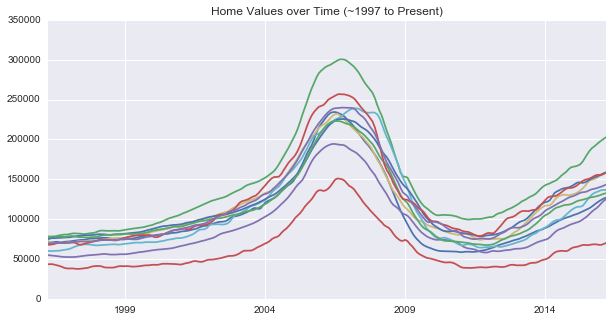

In [30]:


for index, row in df_geo.sort('index', ascending=False).head(10).iterrows():
    
    start_month = int(year_lst[0].split("-")[1])
    start_year = int(year_lst[0].split("-")[0])
    date_range = pd.date_range(start=pd.datetime(start_year, start_month, 1), periods=len(year_lst), freq='M')
    over_time = pd.Series(row[year_lst].tolist(),index=date_range)
    
    over_time.plot(figsize=(10, 5), title="Home Values over Time (~1997 to Present)");

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


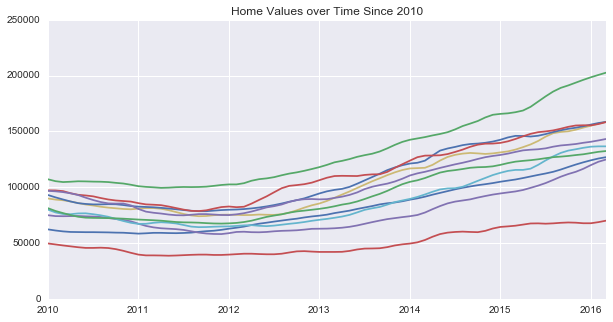

In [31]:


for index, row in df_geo.sort('index', ascending=False).head(10).iterrows():
    
    start_month = int(year_lst[0].split("-")[1])
    start_year = int(year_lst[0].split("-")[0])
    date_range = pd.date_range(start=pd.datetime(start_year, start_month, 1), periods=len(year_lst), freq='M')
    over_time = pd.Series(row[year_lst].tolist(),index=date_range)

    recent_dates = over_time[over_time.index.year >= 2010]
    recent_dates.plot(figsize=(10, 5), title="Home Values over Time Since 2010");
    

## Near a coastline


In [32]:
        
def convert_lines():
    with open('data/us_coastlines.geojson') as data_file:    
        data = json.load(data_file)
            
    point_to_line={}
    count = 0

    for feature in data['features']:
        
        feature_name = feature['properties']['NAME'] +" "+ feature['properties']['MTFCC']
        

        if feature_name not in ['Arctic', 'Caribe' ]:
            geom = feature['geometry']['coordinates']
            coordlist = np.asarray(geom)
            x, y = transform(wgs84, cap, coordlist[:, 0],coordlist[:, 1])
            
            line = LineString(zip(x, y))

            point_to_line[str(count) + " " + feature_name]=line
            count+=1
            
    return point_to_line

def measure_distance(points_to_line):
    lines = []
    oceans = []
    cities = []
    
    for index, row in df_geo.iterrows():
        p = Point(row['x_feet'],row['y_feet'])
  
        near_shore = False
        ocean_name = None
    
        
        for name in points_to_line:
            line = points_to_line[name]
            dist = p.distance(line)
            
            if dist < (5280 * 10):
                near_shore = True
                ocean_name = name
                break
        
        lines.append(near_shore)
        oceans.append(ocean_name)
        cities.append(row['CityState'])
    return lines, oceans, cities
                
                    
               
# points_to_line = convert_lines()

# lines, oceans, cities = measure_distance(points_to_line)

# coast_df = pd.DataFrame({'cities' : cities,
#  'lines' : lines,
#  'oceans': oceans
#   })

# coast_df.to_csv('close2oceans.csv')



IndentationError: expected an indented block (<ipython-input-32-f0f22766750e>, line 4)

In [33]:
# merge the files together

coast_df = pd.read_csv('close2oceans.csv')

coast_df['CityState'] = coast_df['cities']
df_geo = pd.merge(df_geo, coast_df, on='CityState', how='inner')

In [34]:
import warnings
warnings.filterwarnings('ignore')

df_out = df_geo[df_geo['lines'] == True]
df_out['ocean name'] = df_out['oceans'].apply(lambda x: x.split(' ')[1])
df_out = df_out[['RegionName_x', 'State_x','ocean name', 'index', '2016-03_x', '2016-03_y', 'growth', 'seasonal use']].sort('index', ascending=False).head(10)
df_out

,RegionName_x,State_x,ocean name,index,2016-03_x,2016-03_y,growth,seasonal use
1903,Golden Gate,FL,Gulf,85.933024,202600,8.40,1.028028,69.4
364,Golden Lakes,FL,Atlantic,83.505419,70000,5.09,0.799486,50.0
356,Palm Springs,FL,Atlantic,83.336956,124800,7.87,0.950000,50.0
1105,Kensington Park,FL,Gulf,83.121668,158600,9.03,0.950800,59.5
106,Leisure City,FL,Atlantic,82.661397,136600,7.49,1.005874,31.4
485,Broadview Park,FL,Atlantic,81.009600,158300,8.18,0.877817,44.3
476,North Lauderdale,FL,Atlantic,80.975046,143200,7.90,0.857328,44.3
131,Naranja,FL,Atlantic,80.963786,157700,8.50,0.968789,31.4
1098,North Sarasota,FL,Gulf,79.780089,128800,7.71,0.685864,59.5
3472,Laurium,MI,Great,79.652994,71600,7.30,0.623583,62.7


## Near Major Airport

### Accessibility: 
Is it near a major airport? Find cities that are within at least 20 miles of major commercial airport.

In [35]:
# Load Airport Data
df_airports = pd.read_csv('data/us_airports.csv')

# There are airports in every little town.
# remove non major airports

major_airports_codes = ["GA","LAX","ORD","DFW","JFK","DEN","SFO","CLT","LAS","PHX","IAH","MIA","SEA","EWR","MCO","MSP","DTW","BOS","PHL","LGA","FLL","BWI","IAD","MDW","SLC","DCA","HNL","SAN","TPA","PDX","STL","HOU","BNA","AUS","OAK","MCI","MSY","RDU","SJC","SNA","DAL","SMF","SJU","SAT","RSW","PIT","CLE","IND","MKE","CMH","OGG","PBI","BDL","CVG","JAX","ANC","BUF","ABQ","ONT","OMA","BUR"]

df_airports = df_airports[df_airports['code'].isin(major_airports_codes)]

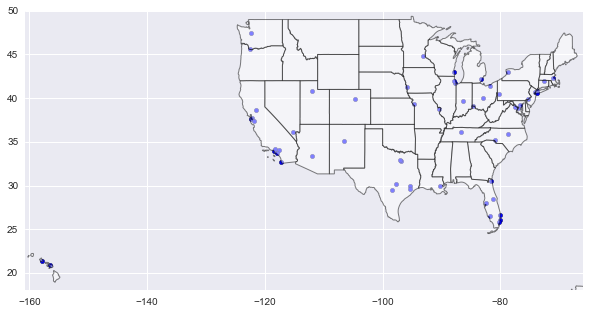

In [36]:
# Sanity Check
# make sure airports are in parts of the states that make sense
# validate that the data is correct (lat, lons for airports fall on the map)

fig = plt.figure(figsize=(10,5))
ax = plt.gca()
add_us_outline(ax)
ax.scatter(df_airports['lon'], df_airports['lat'], marker='o');

In [37]:
#converted units
cap = Proj('+datum=NAD83 +lat_0=32.10 +lat_1=33.53 '
    '+lat_2=32.47 +lon_0=-116.15 +no_defs +proj=lcc +units=us-ft '
    '+x_0=2000000 +y_0=500000', preserve_units=True)

wgs84 = Proj(init='epsg:4326')

def transform_lat_lon(row):
 
    try:
        x, y = transform(wgs84, cap, row['Longitude'], row['Latitude'])
        return x,y
    except:
        return np.nan 

def transform_lat_lon2(row):

    try:
        x, y = transform(wgs84, cap, row['lon'], row['lat'])
        return x,y
    except:
        return np.nan 
    
    
# gett city geo    
df_geo['x_feet'], df_geo['y_feet'] = zip(*df_geo.apply(transform_lat_lon, axis=1).tolist())

df_airports['x_feet'], df_airports['y_feet'] = zip(*df_airports.apply(transform_lat_lon2, axis=1).tolist())


In [38]:
import math
feet_to_mile = 5280.0
radius = 25

def check_location(row):
    center_x, center_y = row['x_feet'], row['y_feet']
    airport_close = False
    
    for index, airport in df_airports.iterrows():
        x, y = airport['x_feet'], airport['y_feet'] 
        eucl_dist = math.sqrt((x - center_x) ** 2 + (y - center_y) ** 2) / feet_to_mile
        if eucl_dist < radius:
            airport_close = True
            break
    
    return airport_close


df_geo['near_airport'] = df_geo.apply(check_location, axis=1)    


In [39]:


df_geo_near_airport = df_geo[df_geo['near_airport'] == True]
# sort descending from the highest index down and limit the top 10

df_out = df_geo_near_airport.sort('index', ascending=False).head(10)
df_out[['RegionName_x', 'State_x','Population', 'index', '2016-03_x', '2016-03_y', 'growth', 'seasonal use']].head(10)


,RegionName_x,State_x,Population,index,2016-03_x,2016-03_y,growth,seasonal use
335,Lehigh Acres,FL,48534,86.148716,126900,9.26,1.147208,55.8
1903,Golden Gate,FL,25388,85.933024,202600,8.40,1.028028,69.4
364,Golden Lakes,FL,NaN,83.505419,70000,5.09,0.799486,50.0
356,Palm Springs,FL,14329,83.336956,124800,7.87,0.950000,50.0
106,Leisure City,FL,23770,82.661397,136600,7.49,1.005874,31.4
1288,Poinciana,FL,NaN,81.054447,132400,9.82,0.880682,57.6
485,Broadview Park,FL,NaN,81.009600,158300,8.18,0.877817,44.3
476,North Lauderdale,FL,34267,80.975046,143200,7.90,0.857328,44.3
131,Naranja,FL,NaN,80.963786,157700,8.50,0.968789,31.4
24,Youngtown,AZ,NaN,80.624740,110900,9.62,1.016364,28.1


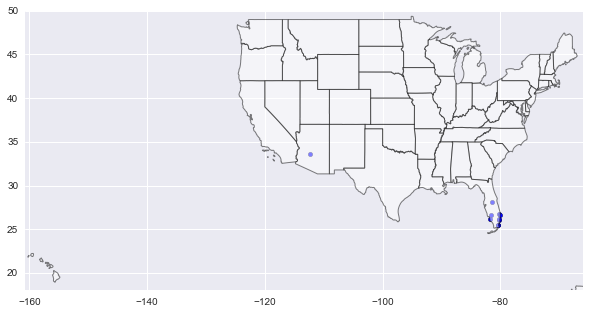

In [40]:
fig = plt.figure(figsize=(10,5))
ax = plt.gca()
add_us_outline(ax)
ax.scatter(df_out['Longitude'], df_out['Latitude'], marker='o');